# End-to-End Example of Statistical Modeling
- Goal: to predict the number of antidiabetic drug prescriptions in Australia for the next 12 months (windows=12)
    - This problem would allow us to gauge the production of antidiabetic drugs, such as to produce enough to meet the demand and but also avoid overproduction.
- Dataset: collected monthly from from 1991 to 2008
    - Test set: the last 36 months

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from scipy.signal import periodogram

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from itertools import product
from tqdm import tqdm
from typing import Union
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../../data/book-time-series-forecasting-in-python/AusAntidiabeticDrug.csv", parse_dates=[0])
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [3]:
df.shape

(204, 2)

## EDA
- From the plot, there is a clear seasonality within a year, where the number of prescriptions is low at the start of the year, dipped in Feb and sharply increase towards the end of the year `m=12`
- Also, there is a upward trend.

In [4]:
fig = px.line(df, x='ds',y='y')
for year in range(1992, 2009):
    fig.add_vline(f"{year}-01-01", line=dict(dash='dot'))

fig.update_layout(
    yaxis_title='Number of anti-diabetic drug prescriptions',
    xaxis_title='Date',
    title="Monthly number of antidiabetic drug prescriptions in Australia between 1991 and 2008"
)  

### Identifying seasonal patterns in a time series: find $m$
- Identify the period of the seasonality

In [5]:
freq = pd.infer_freq(df['ds'])
print(f"Inferred frequency: {freq}")


# Calculate the periodogram
frequencies, spectrum = periodogram(df.set_index('ds')['y'])
# Identify the dominant frequencies (top 3)
top_k = 10
dominant_frequencies = frequencies[spectrum.argsort()[-top_k:][::-1]]
seasonal_period = 1 / dominant_frequencies
# print(f"Dominant frequency: {dominant_frequencies}")
print(f"Potential Seasonal's periods (m): {list(seasonal_period)} ")

Inferred frequency: MS
Potential Seasonal's periods (m): [204.0, 102.0, 68.0, 51.0, 40.8, 34.0, 12.0, 6.0, 29.14285714285714, 4.0] 


- In this problem, we can choose periods $m$ is 4 (quarterly), 6 (half-year), or 12 (yearly) months 

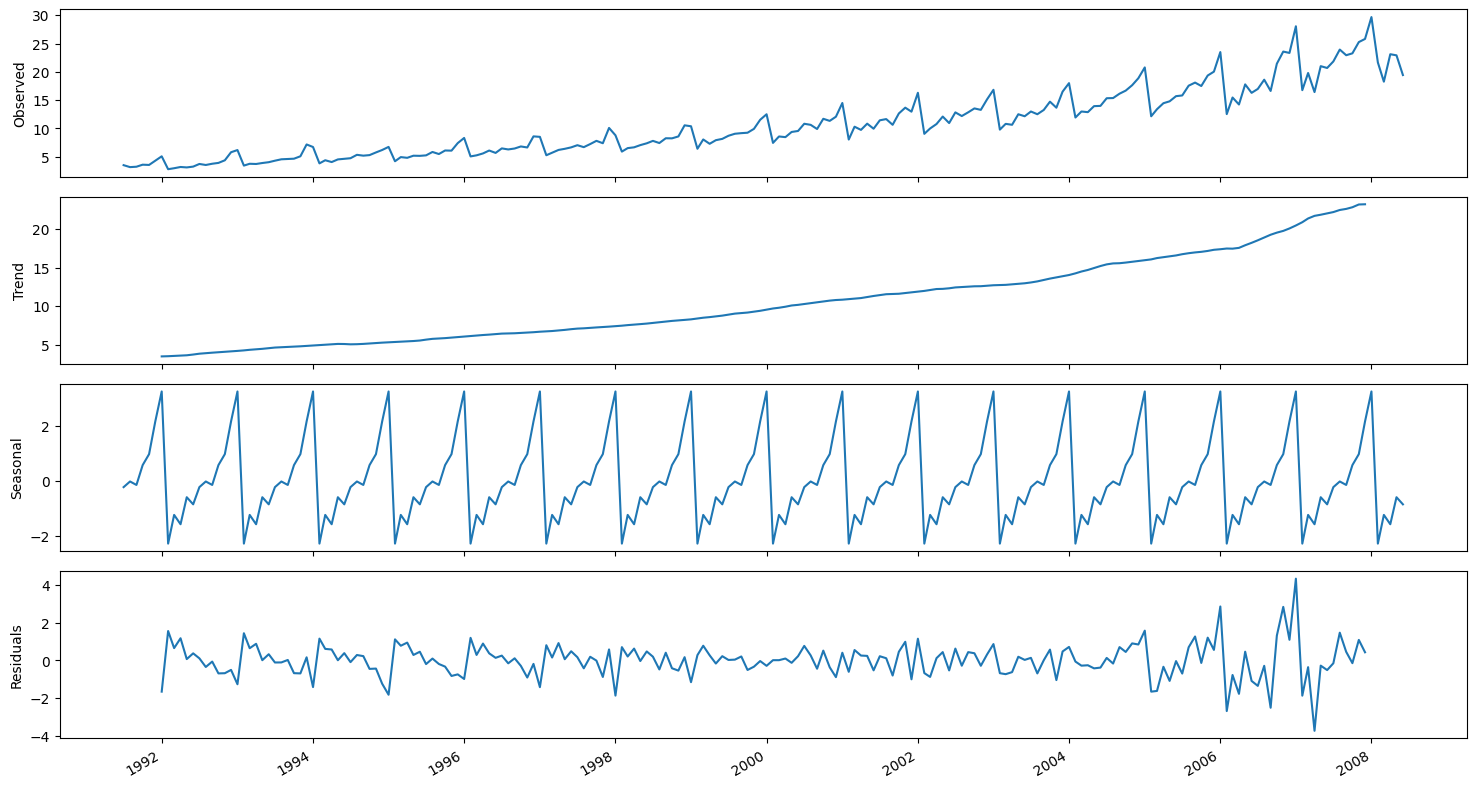

In [6]:
# Decompose the series using the STL function. 
# The period is equal to the frequency m. Since we have monthly data, the period is 12.
def decompose_ts(df, model='additive', period=12):
    decomposition = seasonal_decompose(df, model=model, period=period)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15,8))

    ax1.plot(decomposition.observed)
    ax1.set_ylabel('Observed')

    ax2.plot(decomposition.trend)
    ax2.set_ylabel('Trend')

    ax3.plot(decomposition.seasonal)
    ax3.set_ylabel('Seasonal')

    ax4.plot(decomposition.resid)
    ax4.set_ylabel('Residuals')

    fig.autofmt_xdate()
    plt.tight_layout()

decompose_ts(df.set_index(df['ds'])['y'], period=12)

### Stationary Check: to identify $d$ and $D$

In [7]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [8]:
check_stationarity(df['y'])

ADF Statistic : 3.14519, p-value: 1.00000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
KPSS Statistic: 2.01313, p-value: 0.01000
Non-stationary


In [9]:
# The time series is not stationary.
# Apply a transformation to our data in order to make it stationary. Let’s apply a first-order differencing using numpy.

df_diff_1 = np.diff(df['y'], n=1)
check_stationarity(df_diff_1)

ADF Statistic : -2.49517, p-value: 0.11665
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
KPSS Statistic: 0.13411, p-value: 0.10000
Non-stationary


In [10]:
df_diff_1_seasonal = np.diff(df_diff_1, n=12)
check_stationarity(df_diff_1_seasonal)

ADF Statistic : -19.84844, p-value: 0.00000
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
KPSS Statistic: 0.08967, p-value: 0.10000
Stationary


- Since we took one difference and one seasonal difference, this means that $d=1$ and $D=1$

## Modeling

### Train-Test Split
- There is 204 data points, and the last 36 months will be used for test set, so the the first 168 will be used for training

In [11]:
train = df['y'][:168]
test = df.iloc[168:]

### General Modeling: to identify $p$, $q$, and $P$, $Q$

In [13]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [14]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12
SARIMA_result_df = optimize_SARIMAX(train, None, order_list, d, D, s)

100%|██████████| 256/256 [06:53<00:00,  1.61s/it]


In [16]:
SARIMA_result_df.head()

,"(p,q,P,Q)",AIC
0,"(1, 0, 2, 3)",25.789556
1,"(3, 1, 1, 3)",270.951096
2,"(3, 3, 1, 3)",271.348263
3,"(3, 2, 1, 3)",272.222637
4,"(3, 3, 0, 1)",272.580412


- Since the first (1,0,2,3) with the lowest AIC, but based on the residual analysis, the residuals from this model is not approximately to white noise

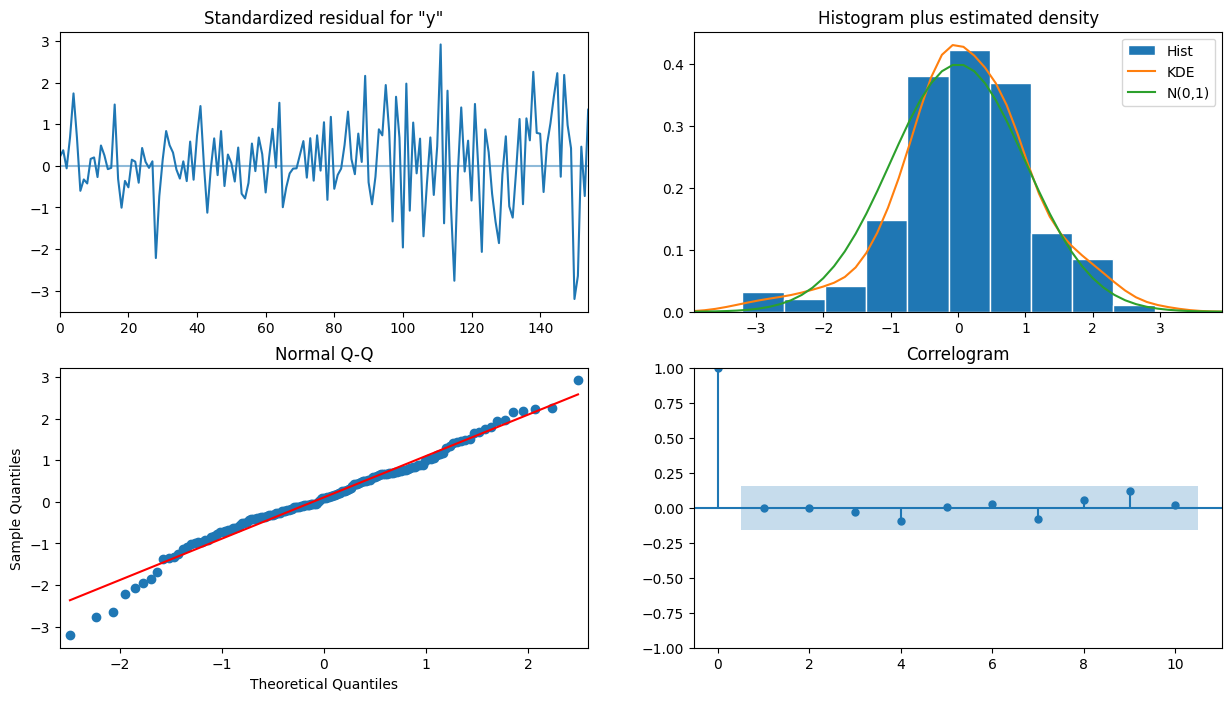

In [18]:
# perform residual analysis on SARIMA(2,2,2)(1,1,2)_{12}
SARIMA_model = SARIMAX(train, 
                       order=(3,1,1), # p,d,q
                       seasonal_order=(1,1,3,12), # P, D, Q, S (or M)
                       simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
 
SARIMA_model_fit.plot_diagnostics(figsize=(15,8));

In [19]:
residuals = SARIMA_model_fit.resid
jb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
(jb_df["lb_pvalue"] >= 0.05).sum() == 10 # this to ensure all the lags, the p-value exceed 0.05, so we cannot reject the null hypo

True

In [20]:
def evaluate_with_rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [22]:
TRAIN_LEN = len(train) # 168
HORIZON = len(test)    # 36
WINDOW = 12

test['last_season'] = evaluate_with_rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')
test['SARIMA'] = evaluate_with_rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

## Evaluate

In [23]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
mape_naive_seasonal = mape(test.y, test.last_season)
mape_SARIMA = mape(test.y, test.SARIMA)
print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.563296773232024


In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[-40:].ds, y=df[-40:]['y'], name='actual', line = dict(color='royalblue')))

for pred_type in ['last_season', 'SARIMA']: 
    fig.add_trace(go.Scatter(x=test.ds, y=test[pred_type], name=pred_type, line = dict(dash='dash')))

fig.update_layout(
    yaxis_title='Date',
    xaxis_title='Number of anti-diabetic drug prescriptions',
    title='Prediction on Test Set'
)  
fig.show()